In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os, os.path
import glob
import keras
import itertools
from pydot import Dot
from PIL import Image
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,Activation
from keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator,img_to_array,image
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K

Using TensorFlow backend.


## Model

The model is the convolutional neural network InceptionV3 with weights trained on Imagenet. The top of the architecture is replaced with a fully connected layer with 2048 units and 50% dropout followed by an output layer with 257 units according to the new classes. The layers in the base model is frozen and only the top will be trained on the new data. This is because the network is already trained on finding features in images and will be able to transfer the predictive power on new classes of images.

In [2]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [3]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [4]:
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)

In [5]:
output = Dense(257, activation='softmax')(x)

In [6]:
model = Model(inputs=base_model.input, outputs=output)

In [7]:
for layer in base_model.layers:
    layer.trainable = False

The model is compiled with the Adam optimizer, categorical crossentropy loss and accuracy for evaluation.

In [8]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Data preprocessing

The dataset consists of 30,607 images belonging to 257 classes. The data is generated in batches of size 32 and split into a train and a test set 90/10. 

In [10]:
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)

In [11]:
train_data = datagen.flow_from_directory(
        '/Users/andreashaggstrom/Downloads/Data Science/256_ObjectCategories',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical',subset='training')

Found 27644 images belonging to 257 classes.


In [12]:
val_data = datagen.flow_from_directory(
        '/Users/andreashaggstrom/Downloads/Data Science/256_ObjectCategories',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical' ,subset='validation',shuffle=True)

Found 2963 images belonging to 257 classes.


In [13]:
test_data = datagen.flow_from_directory(
        '/Users/andreashaggstrom/Downloads/Data Science/256_ObjectCategories',
        target_size=(299, 299),
        batch_size=1,
        class_mode=None ,subset='validation',shuffle=False)

Found 2963 images belonging to 257 classes.


The classes are evenly distributed with a few classes with more images.

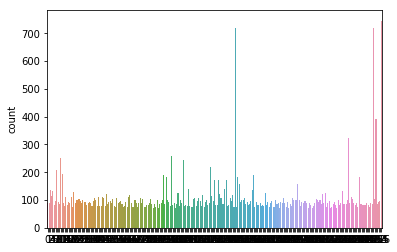

In [14]:
sns.countplot(train_data.classes)

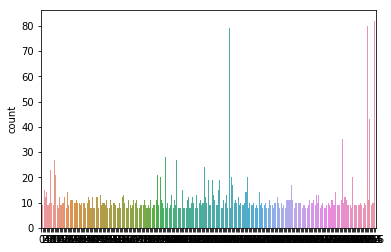

In [15]:
sns.countplot(test_data.classes)

## Training the model

The model is trained for a duration of 8 epochs.

In [16]:
history = model.fit_generator(train_data,
                         epochs = 8,
                        validation_data = val_data)

Epoch 1/8
864/864 [==============================] - 7588s 9s/step - loss: 2.3816 - acc: 0.5236 - val_loss: 0.7997 - val_acc: 0.8012
Epoch 2/8
864/864 [==============================] - 7578s 9s/step - loss: 1.2111 - acc: 0.7051 - val_loss: 0.7303 - val_acc: 0.8245
Epoch 3/8
864/864 [==============================] - 7578s 9s/step - loss: 1.0497 - acc: 0.7395 - val_loss: 0.6714 - val_acc: 0.8232
Epoch 4/8
864/864 [==============================] - 7587s 9s/step - loss: 0.9673 - acc: 0.7550 - val_loss: 0.6664 - val_acc: 0.8269
Epoch 5/8
864/864 [==============================] - 7563s 9s/step - loss: 0.8972 - acc: 0.7706 - val_loss: 0.6757 - val_acc: 0.8292
Epoch 6/8
864/864 [==============================] - 7566s 9s/step - loss: 0.8711 - acc: 0.7774 - val_loss: 0.6695 - val_acc: 0.8319
Epoch 7/8
864/864 [==============================] - 7580s 9s/step - loss: 0.8207 - acc: 0.7905 - val_loss: 0.6396 - val_acc: 0.8410
Epoch 8/8
864/864 [==============================] - 7575s 9s/step - 

The model is converging at the 8th epoch with an accuracy reaching 90%.

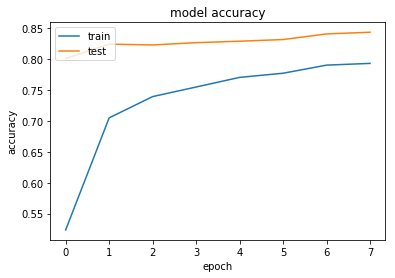

In [17]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

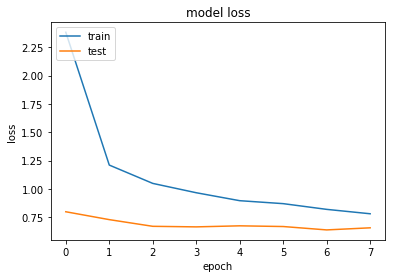

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Predictions and evaluation

In [19]:
predictions = model.predict_generator(test_data)

In [20]:
np.argmax(predictions,axis=1)

array([  0,   0,   0, ..., 256, 153, 111])

In [21]:
val_preds = np.argmax(predictions, axis=1)

In [22]:
val_trues = test_data.classes

In [23]:
val_trues

array([  0,   0,   0, ..., 256, 256, 256], dtype=int32)

In [24]:
labels = test_data.class_indices.keys()

In [25]:
print(classification_report(val_trues, val_preds, target_names=labels))

                               precision    recall  f1-score   support

                     001.ak47       0.55      0.67      0.60         9
            002.american-flag       0.90      1.00      0.95         9
                 003.backpack       0.92      0.80      0.86        15
             004.baseball-bat       0.80      0.67      0.73        12
           005.baseball-glove       0.92      0.86      0.89        14
          006.basketball-hoop       0.80      0.89      0.84         9
                      007.bat       1.00      0.80      0.89        10
                  008.bathtub       0.79      1.00      0.88        23
                     009.bear       1.00      1.00      1.00        10
                 010.beer-mug       1.00      1.00      1.00         9
                011.billiards       0.96      0.89      0.92        27
               012.binoculars       1.00      0.95      0.98        21
                 013.birdbath       0.67      0.89      0.76         9
     

In [26]:
img=image.load_img('/Users/andreashaggstrom/Downloads/Data Science/256_ObjectCategories/038.chimp/038_0014.jpg', 
               target_size=(299,299))
img = keras.preprocessing.image.img_to_array(img)
img = img.astype("float") / 255.0
img = np.expand_dims(img, axis=0)
pre = model.predict(img)
np.argmax(pre)

37